In [1]:
import os
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

In [ ]:
# Reapplying preprocessing steps as defined earlier

# Reload the dataset
file_path = "C:/Users/mahmu/iCloudDrive/Study/Winter_24_25/ABDA/Project/dataset/AirQualityUCI.xlsx"
air_quality_data = pd.read_excel(file_path, sheet_name=0, na_values=-200)
# standardizing column names
cleaned_data.columns = [col.strip().replace(" ", "_").replace("(", "").replace(")", "") for col in cleaned_data.columns]

# normalising columns using MinMaxScaler
# initialising the scaler
scaler = MinMaxScaler()

# fitting and transforming cleaned data
scaled_data = scaler.fit_transform(cleaned_data)

# extracting in dataframe
normalised_data = pd.DataFrame(scaled_data, columns=cleaned_data.columns)

In [2]:
# Select relevant columns for Gamma Regression
relevant_columns = ['CO(GT)', 'NOx(GT)', 'NO2(GT)', 'NMHC(GT)']
cleaned_data = air_quality_data[relevant_columns].dropna()

# Rename columns for compatibility
cleaned_data.columns = ['COGT', 'NOxGT', 'NO2GT', 'NMHCGT']

In [3]:
# Prepare the data for Gamma Regression
y = cleaned_data['COGT'].values  # Target variable (COGT)
predictors = cleaned_data[['NOxGT', 'NO2GT', 'NMHCGT']].values
X = np.hstack((np.ones((predictors.shape[0], 1)), predictors))  # Add intercept column
n_samples, n_features = X.shape

In [4]:
# Reinitialize parameters and rerun the Bayesian workflow
# Initialize parameters
np.random.seed(42)
alpha = 2.0  # Initial shape parameter for Gamma
beta = np.zeros(n_features)  # Coefficients including intercept
sigma_beta = 10  # Prior standard deviation for coefficients

In [5]:
# Define the log-likelihood for Gamma regression
def log_likelihood(alpha, beta, X, y):
    mu = np.exp(np.dot(X, beta))  # Compute the expected value
    return np.sum(stats.gamma.logpdf(y, a=alpha, scale=mu / alpha))

# Define the log-prior for parameters
def log_prior(alpha, beta):
    log_prior_alpha = stats.gamma.logpdf(alpha, a=2, scale=1)  # Prior for alpha
    log_prior_beta = np.sum(stats.norm.logpdf(beta, loc=0, scale=sigma_beta))  # Priors for beta
    return log_prior_alpha + log_prior_beta

# Define the log-posterior
def log_posterior(alpha, beta, X, y):
    return log_likelihood(alpha, beta, X, y) + log_prior(alpha, beta)

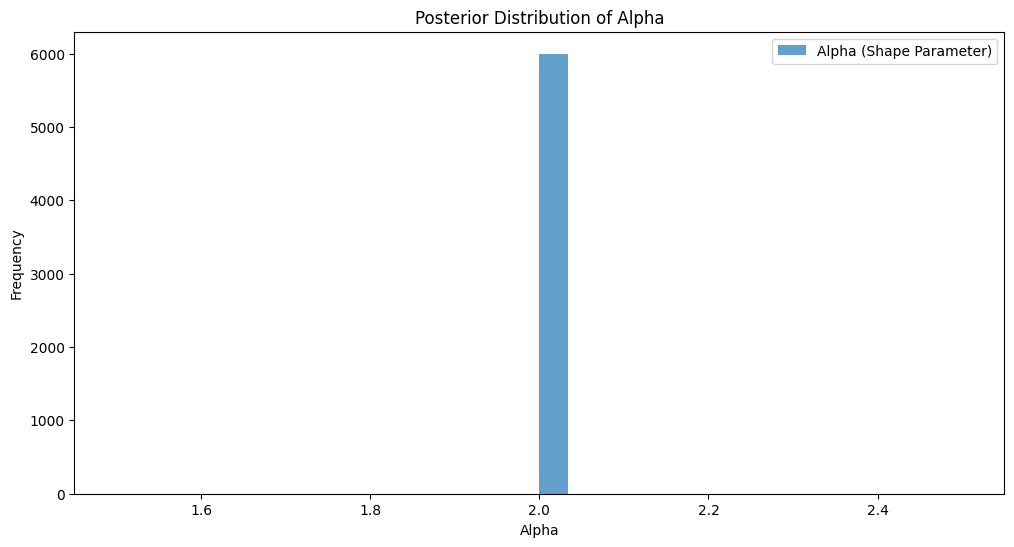

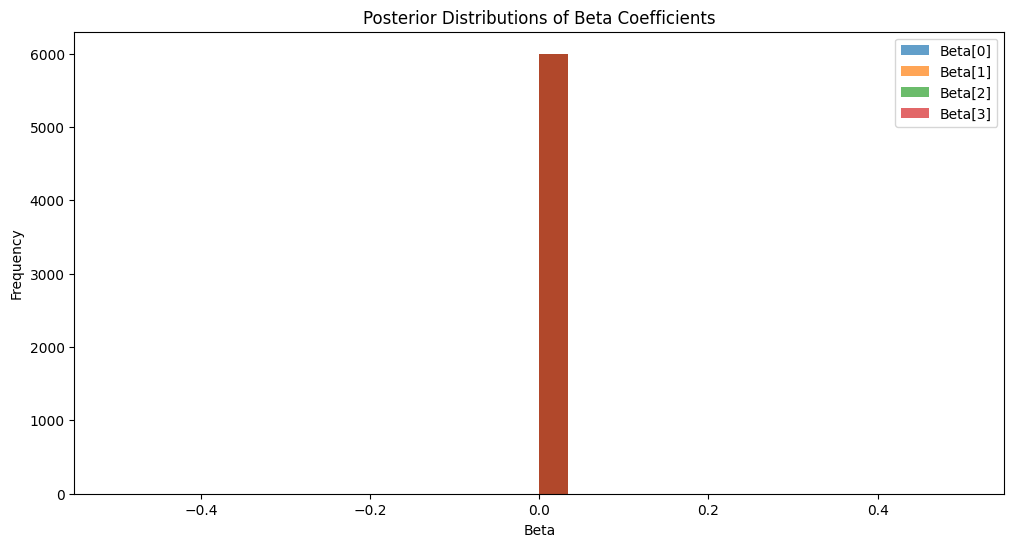

In [6]:
# Reducing iterations for faster execution
n_iterations = 6000  # Reduced from 5000
alpha_samples = []
beta_samples = []

current_alpha = alpha
current_beta = beta

# Optimized sampling process
for i in range(n_iterations):
    # Propose new alpha and beta
    proposed_alpha = np.abs(current_alpha + np.random.normal(0, 0.1))
    proposed_beta = current_beta + np.random.normal(0, 0.1, size=n_features)
    
    # Compute log-posterior for current and proposed values
    log_post_current = log_posterior(current_alpha, current_beta, X, y)
    log_post_proposed = log_posterior(proposed_alpha, proposed_beta, X, y)
    
    # Acceptance probability
    acceptance_prob = np.exp(log_post_proposed - log_post_current)
    
    # Accept or reject the proposed values
    if np.random.rand() < acceptance_prob:
        current_alpha = proposed_alpha
        current_beta = proposed_beta
    
    # Store samples
    alpha_samples.append(current_alpha)
    beta_samples.append(current_beta.copy())

# Convert samples to arrays for analysis
alpha_samples = np.array(alpha_samples)
beta_samples = np.array(beta_samples)

# Plot the posterior distributions
plt.figure(figsize=(12, 6))
plt.hist(alpha_samples, bins=30, alpha=0.7, label='Alpha (Shape Parameter)')
plt.title('Posterior Distribution of Alpha')
plt.xlabel('Alpha')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
for i in range(n_features):
    plt.hist(beta_samples[:, i], bins=30, alpha=0.7, label=f'Beta[{i}]')
plt.title('Posterior Distributions of Beta Coefficients')
plt.xlabel('Beta')
plt.ylabel('Frequency')
plt.legend()
plt.show()


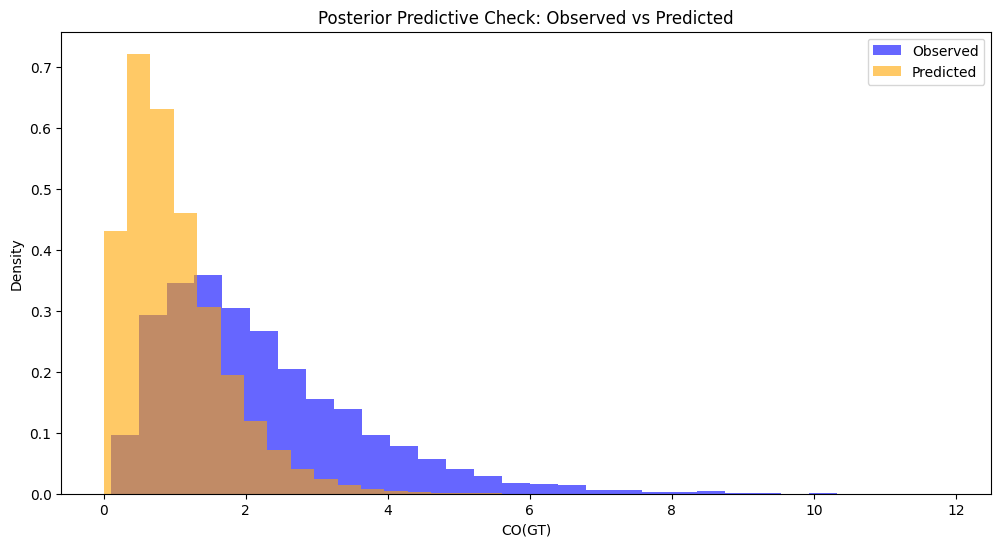

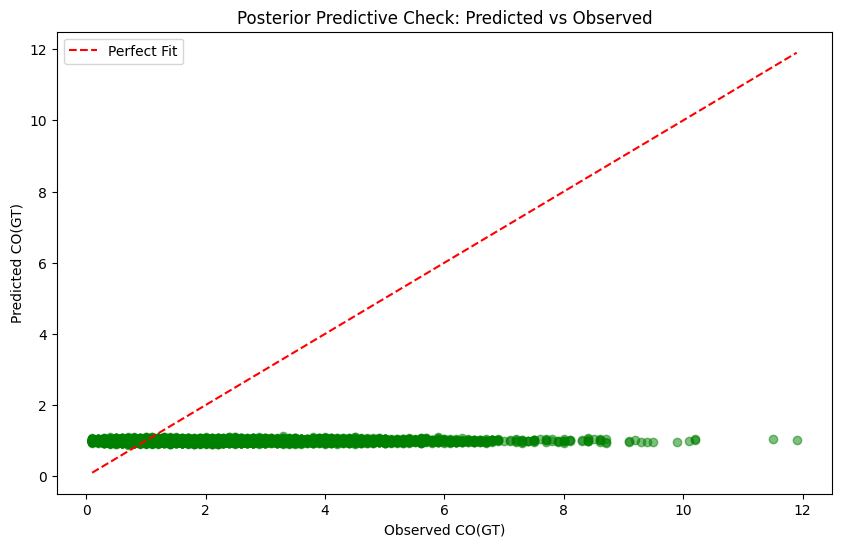

In [7]:
# Posterior Predictive Checks for Gamma Regression

# Generate posterior predictive samples for y
posterior_predictive_y = []
for alpha, beta in zip(alpha_samples[-500:], beta_samples[-500:]):  # Use the last 500 samples
    mu = np.exp(np.dot(X, beta))
    y_pred = np.random.gamma(shape=alpha, scale=mu / alpha, size=len(y))
    posterior_predictive_y.append(y_pred)

posterior_predictive_y = np.array(posterior_predictive_y)

# Plot observed vs. predicted distributions
plt.figure(figsize=(12, 6))
plt.hist(y, bins=30, density=True, alpha=0.6, color='blue', label='Observed')
plt.hist(posterior_predictive_y.flatten(), bins=30, density=True, alpha=0.6, color='orange', label='Predicted')
plt.title('Posterior Predictive Check: Observed vs Predicted')
plt.xlabel('CO(GT)')
plt.ylabel('Density')
plt.legend()
plt.show()

# Plot predicted vs observed scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y, np.mean(posterior_predictive_y, axis=0), alpha=0.5, color='green')
plt.plot([min(y), max(y)], [min(y), max(y)], 'r--', label='Perfect Fit')
plt.title('Posterior Predictive Check: Predicted vs Observed')
plt.xlabel('Observed CO(GT)')
plt.ylabel('Predicted CO(GT)')
plt.legend()
plt.show()